# Generate composite pulses based on a reference hard 90 degree pulse and simulate their amplitude and frequency profile

In [70]:
# import required external modules
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
%matplotlib inline

# import internal modules
from nmr_concepts.bloch_sim import simulate_amp, simulate_freq, simulate_trajectory
from nmr_concepts.composite_pulse import composite_rf


## Input parameters for the composite pulse generation

In [71]:
LIST_FLIP_ANGLES = np.array([90, 180, 90])  # --> the flip angles (degrees), in order, required for the composite pulse
LIST_PHASE = np.array([0, 90, 0])  # --> the corresponding pulse phase for each flip angle above
DURATION_REFERENCE_90_US = 100.0  # --> duration (in us) of the reference hard 90 pulse, based on which the duration of all the flip angles are calculated
NUM_POINTS_REF_90 = 20  # --> number of points to use for the reference 90
FREQ_OFFSET = 0  # frequency offset of the pulse

# Calculate the hard pulse amplitude in Hz
rf_90_amp_hz = 1 / (4 * DURATION_REFERENCE_90_US * 1e-6)
print(rf_90_amp_hz)

2500.0


## Generate the composite pulse

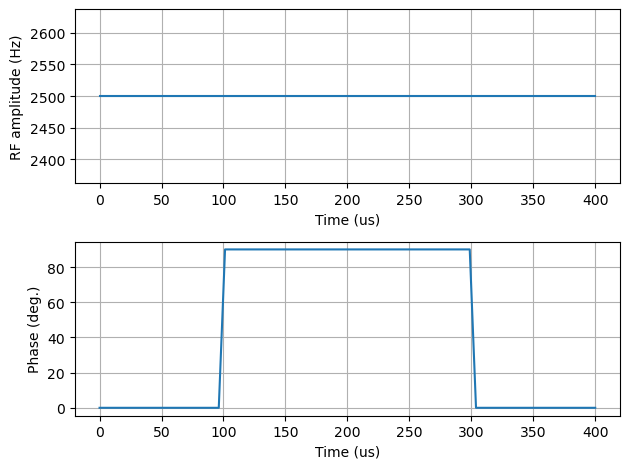

In [72]:
amp_mod, _, phase_mod, time_axis, duration_composite_us = composite_rf(
    list_flip_angle=LIST_FLIP_ANGLES,
    list_phase_angle=LIST_PHASE,
    duration_ref_90=DURATION_REFERENCE_90_US,
    pnts_ref_90=NUM_POINTS_REF_90,
    freq_offset=FREQ_OFFSET,
)

# Plot
fig_rf = plt.figure()
plt_amp_mod = fig_rf.add_subplot(211)
plt_phs_mod = fig_rf.add_subplot(212)

plt_amp_mod.plot(time_axis, amp_mod * rf_90_amp_hz)
plt_amp_mod.set_ylabel("RF amplitude (Hz)")
plt_amp_mod.set_xlabel("Time (us)")

plt_phs_mod.plot(time_axis, phase_mod)
plt_phs_mod.set_ylabel("Phase (deg.)")
plt_phs_mod.set_xlabel("Time (us)")

plt_amp_mod.grid()
plt_phs_mod.grid()

plt.tight_layout()
plt.show()


## Set-up the simulation

In [73]:
# Initial Magnetization
Mx_init = 0
My_init = 0
Mz_init = 1

init_mag = np.array([Mx_init,My_init,Mz_init])
# Nr. of simulation points
sim_points = 256

# Frequency axis bounds in Hz, for frequency simulation
freq_max = 5000
freq_min = - freq_max

# RF amplitude axis bouns in Hz, for amplitude simulation
rf_min = 0
rf_max = 5000

# RF amplitude in Hz to use for frequency reponse simulation
rf_amplitude_hz = rf_90_amp_hz  ## --> this is the optimal amplitude, 
                                    ## modify this parameter to simulate the effect of pulse miscalibrations

## Simulate frequency response: 
### How the magnetization behaves vs Frequency offsets for a given amplitude

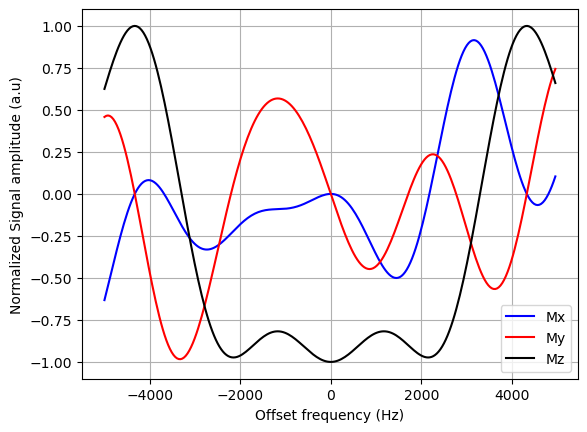

In [74]:
Mx_1, My_1, Mz_1, Mxy_1, freq_range = simulate_freq(
    pulse_length=duration_composite_us,
    sim_points=sim_points,
    rf=amp_mod, pm=phase_mod,
    freq_min=freq_min,
    freq_max=freq_max,
    rf_amplitude=rf_amplitude_hz,
    init_mag=init_mag
)

plt.plot(freq_range, Mx_1, 'b', label='Mx')
plt.plot(freq_range, My_1, 'r', label='My')
plt.plot(freq_range, Mz_1, 'k', label='Mz')
plt.xlabel("Offset frequency (Hz)")
plt.ylabel("Normalized Signal amplitude (a.u)")
plt.legend()
plt.grid()

# Simulate amplitude response: 
### How the magnetization behaves at different amplitudes

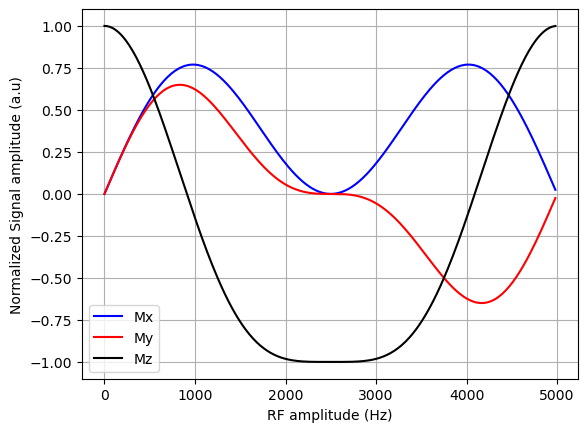

In [75]:
Mx_2, My_2, Mz_2, Mxy_2, rf_range, rf_amp = simulate_amp(
    pulse_length=duration_composite_us,
    sim_points=sim_points,
    rf=amp_mod, pm=phase_mod,
    rf_min=rf_min,
    rf_max=rf_max,
    freq_offset=FREQ_OFFSET,
    init_mag=init_mag,
)

plt.plot(rf_range, Mx_2, 'b', label='Mx')
plt.plot(rf_range, My_2, 'r', label='My')
plt.plot(rf_range, Mz_2, 'k', label='Mz')
plt.xlabel("RF amplitude (Hz)")
plt.ylabel("Normalized Signal amplitude (a.u)")
plt.legend()
plt.grid()

## Simulate the magnetization trajectory during the pulse

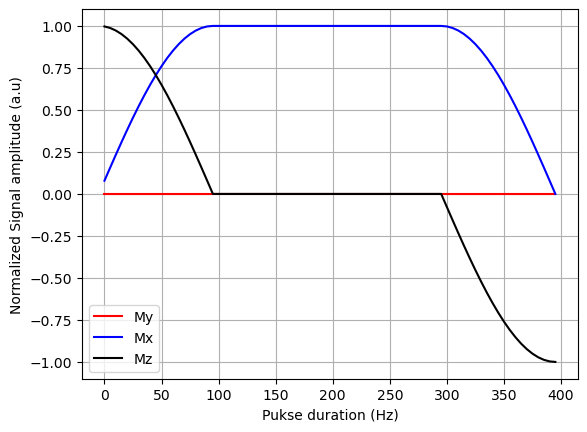

In [76]:
Mx_3, My_3, Mz_3, time_axis = simulate_trajectory(
    pulse_length=duration_composite_us,
    rf=amp_mod, pm=phase_mod,
    rf_amplitude=rf_amplitude_hz,
    freq_offset=FREQ_OFFSET,
    init_mag=init_mag,
)

plt.plot(time_axis, Mx_3, 'r', label='My')
plt.plot(time_axis, My_3, 'b', label='Mx')
plt.plot(time_axis, Mz_3, 'k', label='Mz')
plt.xlabel("Pukse duration (Hz)")
plt.ylabel("Normalized Signal amplitude (a.u)")
plt.legend()
plt.grid()

## Plot the trajectory on a Bloch sphere

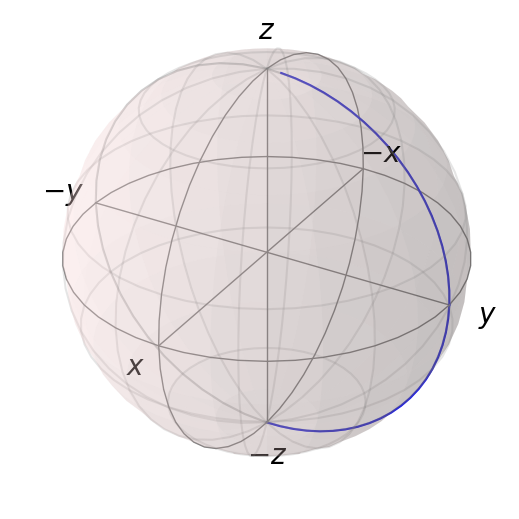

In [77]:
fig_bloch = Bloch()
pnts = [Mx_3, My_3, Mz_3]
fig_bloch.add_points(pnts, "l")
fig_bloch.point_size = [2, 2, 2, 2]
fig_bloch.xlabel = ["$x$", "$-x$"]
fig_bloch.ylabel = ["$y$", "$-y$"]
fig_bloch.zlabel = ["$z$", "$-z$"]
fig_bloch.show()